In [2]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self, N):
        super(Net, self).__init__()
        self.N = N
        self.fc1 = nn.Linear(N*N, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1)
        
        
    def forward(self, x: "(B, N, N)"):
        B = x.shape[0]
        x = x.reshape(B, self.N**2)
        assert x.shape == (B, self.N**2)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        assert x.shape == (B, 1)
        return x[:,0]

In [4]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)

In [5]:
N = 3
model = Net(N)
loss_func = nn.MSELoss(reduction='mean')

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
#weights_init(model)
training_size = 50000

max_val = 2.5
#X = np.random.randint(-5, 5, size=(training_size, N, N))
X = (np.random.rand(training_size, N, N)-0.5) * 2* 2.5
min_X = np.min(X)
max_X = np.max(X)
print(min_X, max_X)

# Get all data between -1 and 1
X = X/abs(max_X-min_X)

Y = np.linalg.det(X)
B = 16
assert training_size%B == 0

losses = []
epochs = 100
for i in range(epochs):
    for j in range(training_size//B):
        x_var = X[j*B:(j+1)*B]
        y_var = Y[j*B:(j+1)*B]
        assert x_var.shape == (B,N,N)
        assert y_var.shape == (B,)
        x_var = t.Tensor(x_var)
        y_var = t.Tensor(y_var)
        
        optimizer.zero_grad()
        y_hat = model(x_var)
        loss = loss_func.forward(y_hat, y_var)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))

        
    if i % 1 == 0:
        print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.numpy()))

-2.499986456515548 2.4999873259936174
Epoch: 0, Loss: 0.0030738799832761288, 
Epoch: 1, Loss: 0.003085360862314701, 
Epoch: 2, Loss: 0.0031089852564036846, 
Epoch: 3, Loss: 0.002713823691010475, 
Epoch: 4, Loss: 0.002268809825181961, 
Epoch: 5, Loss: 0.0006507025100290775, 
Epoch: 6, Loss: 0.0014632954262197018, 
Epoch: 7, Loss: 0.001343066687695682, 
Epoch: 8, Loss: 0.0010018242755904794, 
Epoch: 9, Loss: 0.0007059299969114363, 
Epoch: 10, Loss: 0.0005487733869813383, 
Epoch: 11, Loss: 0.0005480416584759951, 
Epoch: 12, Loss: 0.0006044305046088994, 
Epoch: 13, Loss: 0.0006160910706967115, 
Epoch: 14, Loss: 0.00046536262379959226, 
Epoch: 15, Loss: 0.0006325002177618444, 
Epoch: 16, Loss: 0.0005031722248531878, 
Epoch: 17, Loss: 0.00045184101327322423, 
Epoch: 18, Loss: 0.0005256326985545456, 
Epoch: 19, Loss: 0.0005680961185134947, 
Epoch: 20, Loss: 0.0003752374614123255, 
Epoch: 21, Loss: 0.00026556060765869915, 
Epoch: 22, Loss: 0.00042508001206442714, 
Epoch: 23, Loss: 0.0003498994

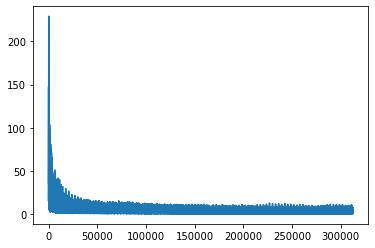

In [9]:
plt.plot(losses)

1.8550056809186934


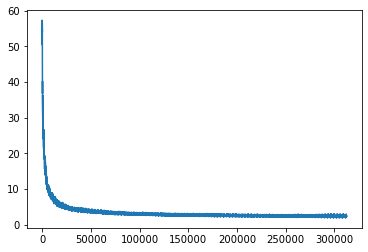

In [15]:
mean_losses = [sum(losses[i:i+100])/100 for i in range(len(losses)-100)]

plt.plot(mean_losses)

print(min(mean_losses))